## Load data

In [61]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np
import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [62]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [63]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

df = pd.concat(dfs).sort_index()

## FILTER DATA

### Filter duplicated scenarios

Filter scenarios that are exactly the same

In [64]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df = df.drop(excluded_routes, level='route_index', axis=0)

### Filter 16 FPS
Carla crashes at 16 so we need to filter this results out

In [65]:
# filter out 16 fps
df = df.drop(16, level='fps', axis=0)

In [66]:
# low12 = df.xs((12, "False"), level=[
#               'fps', 'highquality'], drop_level=False).index

# df = df.drop(low12)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17920 entries, (0, 10, 'False', 0) to (9, 20, 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           17920 non-null  object 
 1   status                             17920 non-null  object 
 2   infractions.collisions_layout      17920 non-null  object 
 3   infractions.collisions_pedestrian  17920 non-null  object 
 4   infractions.collisions_vehicle     17920 non-null  object 
 5   infractions.outside_route_lanes    17920 non-null  object 
 6   infractions.red_light              17920 non-null  object 
 7   infractions.route_dev              17920 non-null  object 
 8   infractions.route_timeout          17920 non-null  object 
 9   infractions.stop_infraction        17920 non-null  object 
 10  infractions.vehicle_blocked        17920 non-null  object 
 11  duration_game        

## PROCESS DATA

### Square error
RMSE

In [68]:
oracle_df = df.xs((20, "True"), level=[
                  'fps', 'highquality'], drop_level=False).sort_index()
oracle_df

route_id                    status                      infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0   20  True        0              RouteScenario_0                 Completed  [Agent collided against object with type=stati...                                []                                                 []                              []                    []                    []                        []                          []                          []     220.250003       848.721987    350.831252       65.000000           0.65   100.000000       0.650000
                    1              RouteScenario_1  Failed - Agent timed out                                                 []                                []                                                 []                              []                    []                    []          [Route timeout.]                          []                          []     251.050004       938.274112    289.985251       84.331496           1.00    84.331496       0.843315
                    2              RouteScenario_2                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []     160.400002       575.346033    272.631122      100.000000           1.00   100.000000       1.000000
                    3              RouteScenario_3                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []      97.550001       340.518655    153.049630      100.000000           1.00   100.000000       1.000000
                    4              RouteScenario_4                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []     181.800003       707.752329    218.597426      100.000000           1.00   100.000000       1.000000
...                                            ...                       ...                                                ...                               ...                                                ...                             ...                   ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
9   20  True        127          RouteScenario_127                 Completed                                                 []                                []                                                 []                      

In [69]:

# oracle driving score per scenario
oracle_vec = oracle_df.groupby('route_index')['driving_score'].mean()
df['rmse'] = (df['driving_score'] - oracle_vec).pow(2).pow(1./2)

df

route_id                    status                      infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score          rmse
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
0   10  False       0              RouteScenario_0  Failed - Agent timed out                                                 []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     301.100004       642.428658    350.831252        2.630572       0.256099    10.271719       0.026306  6.586943e-01
                    1              RouteScenario_1  Failed - Agent timed out                                                 []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     251.100004       536.358014    289.985251       23.249043       0.560619    41.470324       0.232490  6.830993e-01
                    2              RouteScenario_2  Failed - Agent timed out  [Agent collided against object with type=stati...                                []                                                 []                                                 []  [Agent ran a red light 37728 at (x=179.22, y=2...                    []          [Route timeout.]                          []                          []     228.100003       489.848481    272.631122       11.336059       0.455000    24.914415       0.113361  8.823495e-01
                    3              RouteScenario_3  Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     128.100002       277.129590    153.049630       43.246647       0.976153    44.303132       0.432466  5.675335e-01
                    4              RouteScenario_4  Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     190.100003       404.950006    218.597426       16.852092       0.926513    18.188726       0.168521  8.267248e-01
...                                            ...                       ...                                                ...                               ...                                                ...                                                ...             

## Initial investigation

In [70]:
# Driving score per fps
df.xs("True", level='highquality', drop_level=False).groupby('fps')[
    "score_composed"].mean().sort_index(ascending=False)

fps
20    86.023896
18    86.105043
17    83.819818
15    80.233737
14    76.210005
12    60.447086
10    49.340369
Name: score_composed, dtype: float64

In [71]:

# Driving score per repetition
df.groupby(["rep"])["driving_score"].mean()

rep
0    0.701210
1    0.697716
2    0.694470
3    0.696795
4    0.699665
5    0.694105
6    0.698266
7    0.701824
8    0.695624
9    0.695038
Name: driving_score, dtype: float64

#### ^ Pretty consitent repetitions

## RQ1-2

In [72]:
agg = df.loc[:, ['rmse', 'duration_system']
             ].groupby(['fps', 'highquality', "rep"]).mean()
agg

rmse  duration_system
fps highquality rep                           
10  False       0    0.467926       469.834384
                1    0.459554       447.116814
                2    0.453211       452.910228
                3    0.461668       453.921571
                4    0.449690       465.059136
                5    0.457007       494.101757
                6    0.440621       445.578820
                7    0.459502       465.398201
                8    0.497480       465.034573
                9    0.487251       472.697309
    True        0    0.404292       473.943607
                1    0.410053       462.006636
                2    0.390289       468.949601
                3    0.413259       471.472676
                4    0.399919       477.383813
                5    0.410591       468.876125
                6    0.402236       467.465099
                7    0.399717       495.182528
                8    0.409910       468.876868
                9    0.403140       460.705584
12  False       0    0.364805       446.630903
                1    0.353445       435.721332
                2    0.347427       438.867836
                3    0.356122       436.935988
                4    0.362455       466.297423
                5    0.369977       416.148762
                6    0.367927       450.345397
                7    0.340216       463.868283
                8    0.352558       459.960974
                9    0.348108       455.347513
    True        0    0.288465       468.576826
                1    0.297363       462.304133
                2    0.292780       463.284606
                3    0.281322       454.329548
                4    0.293233       461.151303
                5    0.294676       453.819264
                6    0.272015       455.479143
                7    0.302913       444.093640
                8    0.277186       447.365612
                9    0.290557       440.758458
14  False       0    0.215509       455.205322
                1    0.257006       437.019813
                2    0.273752       455.479080
                3    0.254257       451.828628
                4    0.229556       453.684258
                5    0.274560       436.264167
                6    0.267906       464.905674
                7    0.258941       434.661778
                8    0.246273       441.760203
                9    0.244703       443.182152
    True        0    0.158533       487.702097
                1    0.151260       462.385214
                2    0.136389       452.241934
                3    0.150029       468.519552
                4    0.134706       432.952650
                5    0.145478       461.683592
                6    0.149566       451.877312
                7    0.147801       449.798979
                8    0.159645       468.983922
                9    0.147000       474.577370
15  False       0    0.190252       431.432092
                1    0.195012       433.510575
                2    0.211084       430.886723
                3    0.209122       442.052724
                4    0.190423       457.229487
                5    0.209198       434.824454
                6    0.197365       437.533334
                7    0.194880       448.400575
                8    0.223461       436.239918
                9    0.206002       448.966800
    True        0    0.108877       504.996847
                1    0.104408       475.462563
                2    0.122133       481.630894
                3    0.111066       476.534664
                4    0.099511       451.629545
                5    0.100428       472.811552
                6    0.099367       469.624269
                7    0.103812       494.123279
                8    0.104995       463.160047
                9    0.106762       469.303418
17  False       0    0.127735       474.162997
                1    0.141466       465.648682
                2    0.142087       474.463685
                3    0.163518 

In [73]:
vals = set(agg.reset_index()['fps'].values)
vals

{10, 12, 14, 15, 17, 18, 20}

In [74]:
palette = sns.color_palette("deep")

# Access the first two colors by indexing
first_color = palette[0]
second_color = palette[1]

# Print the color values (assuming they are RGB tuples)
print(f"First color: {first_color}")
print(f"Second color: {second_color}")

First color: (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
Second color: (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)


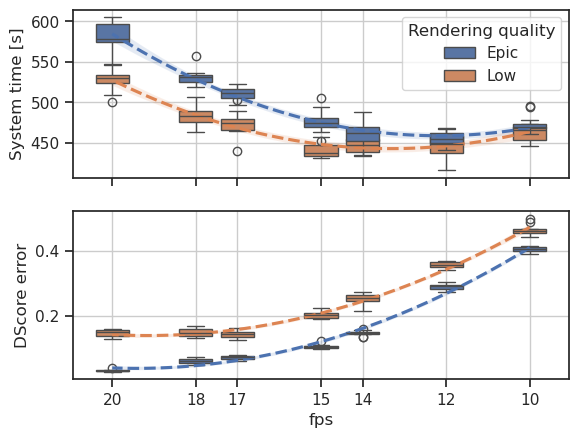

In [75]:
def new_boxplot(agg, ax, col='rmse', stack=True,):

    if stack:
        epicq = agg.xs("True", level='highquality',
                       drop_level=False).reset_index()
        lowq = agg.xs("False", level='highquality',
                      drop_level=False).reset_index()

        ax = sns.boxplot(lowq, x='fps', y=col, hue='highquality', ax=ax, native_scale=True, hue_order=["True", "False"]
                         )

        ax = sns.boxplot(epicq, x='fps', y=col,
                         hue='highquality', ax=ax,  native_scale=True, hue_order=["True", "False"])

        ax = sns.regplot(epicq, x='fps', y=col, ax=ax,
                         order=2, scatter=False, line_kws=dict(linestyle='dashed'),)
        ax = sns.regplot(lowq, x='fps', y=col, ax=ax,  order=2,
                         scatter=False, line_kws=dict(linestyle='dashed'),)
    else:
        ax = sns.boxplot(agg.reset_index(), x='fps', y=col, ax=ax, hue='highquality', native_scale=True
                         )


sns.set_theme(style="ticks", palette="deep")
f, axes = plt.subplots(nrows=2, sharex=True,)
axes[0].invert_xaxis()

stack = True
axes[0].set_ylabel(f"System time [s]")
new_boxplot(agg, ax=axes[0], col='duration_system', stack=stack)
axes[0].grid()
axes[0].set_xticks(list(vals))
axes[0].set_ylabel(f"System time [s]")

new_boxplot(agg, ax=axes[1], col='rmse', stack=stack)
axes[1].get_legend().remove()
axes[1].grid()
axes[1].set_ylabel(f"DScore error")

handles, _ = axes[0].get_legend_handles_labels()

axes[0].legend(handles=handles, labels=["Epic", "Low"],
               title="Rendering quality")

f.savefig('boxplot_rq12.pdf', bbox_inches='tight')

In [76]:
agg_mean = agg.groupby(['fps', 'highquality']).mean()['duration_system']
speedup = abs(round((agg_mean.min() / agg_mean.max() - 1) * 100, 1))
print(
    f"Biggest save between {agg_mean.idxmax()} {agg_mean.max():2f} and {agg_mean.idxmin()} {agg_mean.min():2f} is {speedup} %")

Biggest save between (20, 'True') 581.216915 and (15, 'False') 440.107668 is 24.3 %


### RENDERING ERROR

In [77]:
agg_mean = agg.groupby(['fps', 'highquality']).mean()
ren_err = agg_mean.groupby('fps').agg(list)
ren_err

,rmse,duration_system
fps,,
10,"[0.463391022773125, 0.4043407471464002]","[463.16527940612286, 471.4862535657361]"
12,"[0.3563041190395914, 0.2890509666099223]","[447.01244104709474, 455.11625328697266]"
14,"[0.252246409759649, 0.14804056694452328]","[447.39910749141126, 461.0722622282803]"
15,"[0.20267997071685073, 0.10613588522577758]","[440.1076680714265, 475.92770792189987]"
17,"[0.14479484911227408, 0.07248799778047196]","[473.30378217902035, 510.2990024451166]"
18,"[0.14965510605138793, 0.06247426481748718]","[482.9272712323815, 531.247761124745]"
20,"[0.14707399663790635, 0.03293338512934844]","[527.0863325020298, 581.2169148927554]"


In [78]:
ren_err['rmse'].apply(lambda x: x[0]/x[1])

fps
10    1.146041
12    1.232669
14    1.703901
15    1.909627
17    1.997501
18    2.395468
20    4.465803
Name: rmse, dtype: float64

In [79]:
agg_mean

rmse  duration_system
fps highquality                           
10  False        0.463391       463.165279
    True         0.404341       471.486254
12  False        0.356304       447.012441
    True         0.289051       455.116253
14  False        0.252246       447.399107
    True         0.148041       461.072262
15  False        0.202680       440.107668
    True         0.106136       475.927708
17  False        0.144795       473.303782
    True         0.072488       510.299002
18  False        0.149655       482.927271
    True         0.062474       531.247761
20  False        0.147074       527.086333
    True         0.032933       581.216915

## Total time

In [87]:
n_rows = df['duration_system'].index.size
n_rows

17920

In [85]:
total_hours = df['duration_system'].sum() / 3600
total_hours

2406.1753021848863